## VAE Implementation with MNIST

In [1]:
import random
import numpy as np
import math
import itertools
from IPython import display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils import data
from torchvision import datasets
import torch.nn.functional as F

In [2]:
def same_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

device = 'mps'
same_seed(2023)

In [3]:
n_epoch = 20
batch_size = 32
latent_dim = 32
lr = 0.0005
model_save = 'model.pth'

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [5]:
train_set = datasets.MNIST(root='./', train=True,download=True, transform=transform)
                                
test_set = datasets.MNIST(root='./', train=False,download=True, transform=transform)
                                       
train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size

train_set, val_set = torch.utils.data.random_split(dataset=train_set, lengths=[train_size, val_size])

train_loader = data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = data.DataLoader(dataset=val_set,batch_size=batch_size,shuffle=True)                               
test_loader = data.DataLoader(test_set, batch_size=batch_size,shuffle=False)  

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=5, stride=1, padding=2), #[16,28,28]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2), #[14,14]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2), #[7,7]
            nn.ReLU(),
            nn.Flatten(start_dim=1,end_dim=-1),
        )

        self.fc1 = nn.Linear(128*7*7, latent_dim)
        self.fc2 = nn.Linear(128*7*7, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,128*7*7),
            nn.ReLU(),
            nn.Unflatten(dim=1,unflattened_size=(128,7,7)),
            nn.ConvTranspose2d(128,64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1, kernel_size=2, stride=2, padding=0),
            nn.Tanh(),
        )
    
    def reparameterize(self, mu, logVar):
        std = torch.exp(logVar /2)
        eps = torch.rand_like(std)
        
        return mu + eps* std
    
    def forward(self, x):
        encoded = self.encoder(x)
        mu, logVar = self.fc1(encoded), self.fc2(encoded)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar, z
        

In [7]:
x = torch.randn((128,1,28,28))
x = nn.Flatten(start_dim=1)(x)
print("After Flatten:", x.shape)
x = nn.Unflatten(dim=1,unflattened_size=(1,28,28))(x)
print("After Unflatten:", x.shape)

After Flatten: torch.Size([128, 784])
After Unflatten: torch.Size([128, 1, 28, 28])


In [8]:
model = VAE(latent_dim=4).to(device)

In [9]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=3e-4) 

In [10]:
def Train(n_epoch, batch, model_save):
    for epoch in range(n_epoch):
        total_loss = 0

        # Training
        model.train()
        train_loss = []
        idx = 0
        for image, _ in train_loader:
            image = image.to(device, dtype=torch.float)
            image = image.view(-1,1,28,28)
            reconstruct, mu, logVar, _ = model(image)

            # Loss 
            KL = 0.5 * torch.mean(-1 - logVar + mu.pow(2) + logVar.exp())
            BCE = F.mse_loss(reconstruct, image, size_average=False,reduction='sum')
            loss = KL+BCE

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            print('[Epoch %d | %d/%d] loss: %.4f' %
                 ((epoch+1), idx*batch, len(train_loader)*batch, loss.item()), end='\r')
            idx += 1
        total_loss = sum(train_loss)/len(train_loader)
        print("\n  Training loss:%.4f " % total_loss)

        # Validation
        model.eval()
        valid_loss = []
        with torch.no_grad():
            for image, _ in valid_loader:
                image = image.to(device, dtype=torch.float)
                image = image.view(-1,1,28,28)
                reconstruct, mu, logVar, _ = model(image)
                
                # Loss 
                KL = 0.5 * torch.mean(-1 - logVar + mu.pow(2) + logVar.exp())
                BCE = F.mse_loss(reconstruct, image, size_average=False,reduction='sum')
                loss = KL+BCE

                valid_loss.append(loss.item())
            total_loss = sum(valid_loss)/len(valid_loader)
            print(" Validation loss:%.4f " % total_loss)

In [11]:
Train(n_epoch, batch_size, model_save)

/Users/lerong/miniconda3/envs/general_env/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Epoch 1 | 53984/54016] loss: 6074.97366
  Training loss:13493.0484 
 Validation loss:12591.5311 
[Epoch 2 | 53984/54016] loss: 5399.94433
  Training loss:12449.7389 
 Validation loss:12168.4971 
[Epoch 3 | 53984/54016] loss: 6258.78370
  Training loss:12091.5389 
 Validation loss:11896.2062 
[Epoch 4 | 53984/54016] loss: 5421.30279
  Training loss:11875.9564 
 Validation loss:11746.2251 
[Epoch 5 | 53984/54016] loss: 5999.33152
  Training loss:11747.1750 
 Validation loss:11677.6175 
[Epoch 6 | 53984/54016] loss: 6453.66652
  Training loss:11656.7684 
 Validation loss:11588.0510 
[Epoch 7 | 53984/54016] loss: 5746.67099
  Training loss:11592.0870 
 Validation loss:11530.6902 
[Epoch 8 | 53984/54016] loss: 5523.20318
  Training loss:11538.7250 
 Validation loss:11482.0278 
[Epoch 9 | 53984/54016] loss: 6036.03422
  Training loss:11494.8239 
 Validation loss:11438.3741 
[Epoch 10 | 53984/54016] loss: 5044.98930
  Training loss:11458.2071 
 Validation loss:11416.8404 
[Epoch 11 | 53984/5

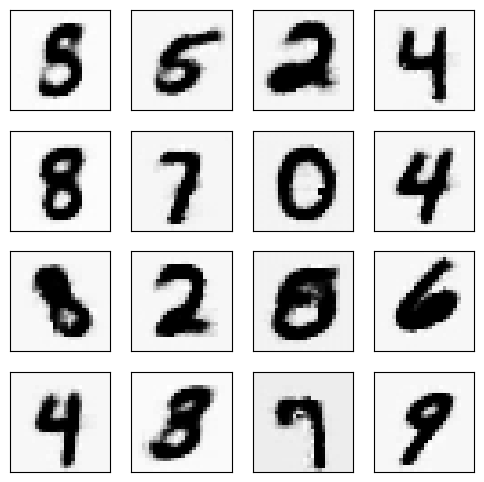

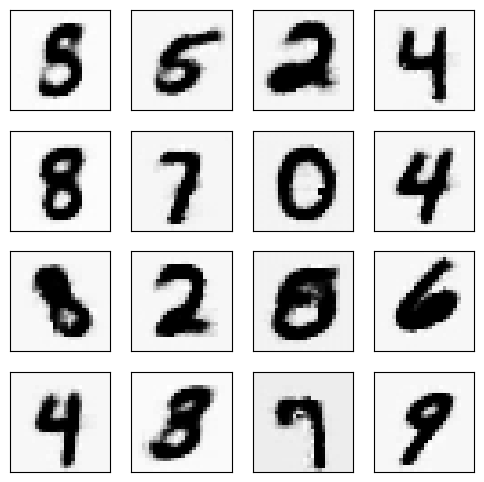

In [12]:
fixed_number_samples = 16

size_figure_grid = int(math.sqrt(fixed_number_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)


model.to('cpu')
model.eval()

for batch_idx, samples in enumerate(train_loader):
    if batch_idx==0:
        img, _ = samples
        reconstruct,_,_,_ = model(img)
        for k in range(fixed_number_samples):
            i = k//4
            j = k%4
            ax[i,j].cla()
            ax[i,j].imshow(reconstruct[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    else:
        pass

## References
- https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
- https://arxiv.org/pdf/1907.08956v1.pdf
- https://stats.stackexchange.com/questions/562374/implementing-a-vae-in-pytorch-extremely-negative-training-loss